In [1]:
import math

import scipy
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

from linear_regression.linear_regression import noisy_line, BayesianLinearRegression, plot_line

sns.set(font_scale=1.5, palette='colorblind')

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
palette = sns.color_palette('colorblind')

In [3]:
xs, ys = noisy_line(2, 3, 0.25, 100, (-1, 1))
y_f = lambda x: 2 * x + 3
y = y_f(xs)

(<Figure size 1080x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11aa21240>)

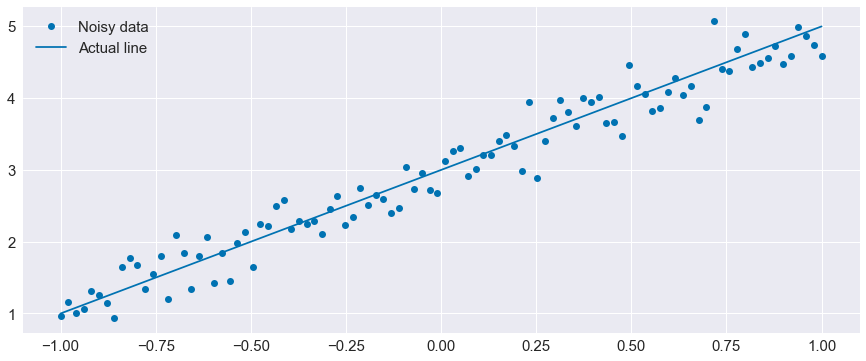

In [4]:
plot_line(xs, y, ys)

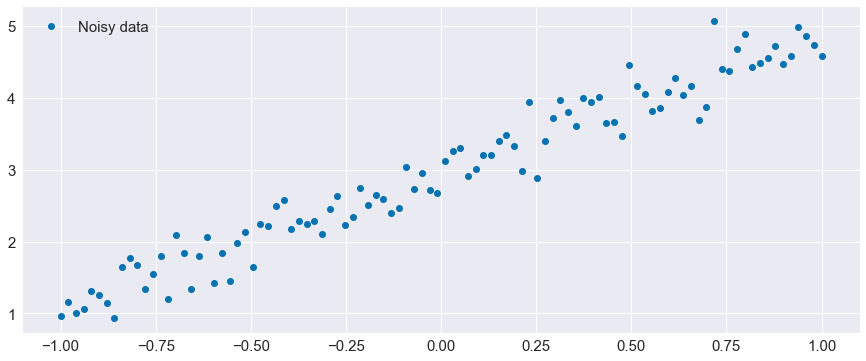

In [5]:
f, ax = plot_line(xs, ys=ys)

In [6]:
f.savefig('/Users/srom/workspace/romainstrock.com/assets/img/linear_regression/dataset.png', bbox_inches='tight')

In [7]:
blr = BayesianLinearRegression()

In [8]:
%%time
num_samples = 5000
burnin = 1000
initial_parameters = [2.5, 2.5, 0.3]

init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    draws = blr.metropolis_hasting(
        sess, 
        xs, 
        ys, 
        num_samples, 
        initial_parameters, 
        proposal_widths=[1e-2, 1e-2, 1e-3],
        bounds=[[1.0, 5.0], [1.0, 5.0], [0.1, 1.0]],
        burnin=burnin,
    )

CPU times: user 8.19 s, sys: 570 ms, total: 8.76 s
Wall time: 8.29 s


In [9]:
posterior_vals = np.exp(np.array([p for _, p in draws]))
idx = np.argmax(posterior_vals)
best_parameters = draws[idx][0]
best_parameters

array([1.91922651, 2.96744551, 0.25081479])

In [10]:
def plot_distributions(draws):
    f, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    dist_slope = np.array([p[0] for p, _ in draws])
    dist_intercept = np.array([p[1] for p, _ in draws])
    dist_sigma = np.array([p[2] for p, _ in draws])
    
    axes[0].hist(dist_slope)
    axes[0].set_title('Slope')
    
    axes[1].hist(dist_intercept)
    axes[1].set_title('Intercept')
    
    axes[2].hist(dist_sigma)
    axes[2].set_title('Sigma')

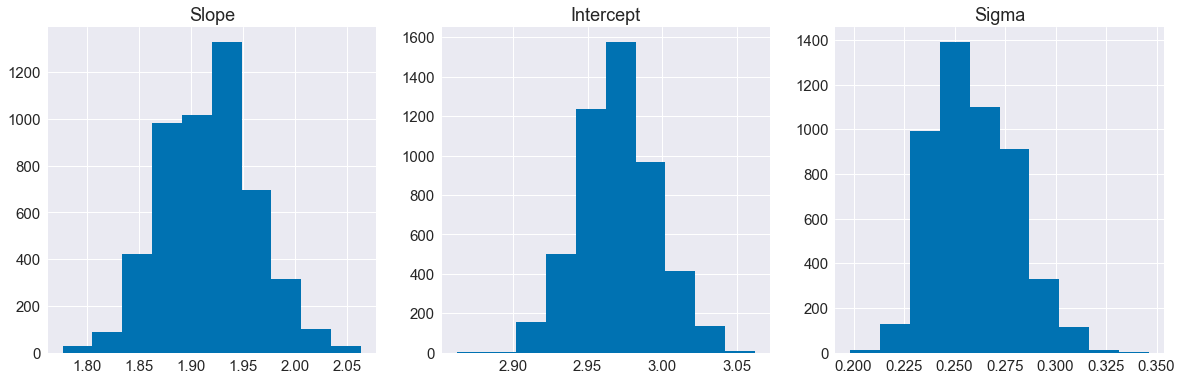

In [11]:
plot_distributions(draws)

In [12]:
y_hat_f = lambda x: best_parameters[0] * x + best_parameters[1]
y_hat = y_hat_f(xs)

draw_data = y_hat + np.random.normal(loc=0, scale=best_parameters[2], size=len(xs))

(<Figure size 1080x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11ae7fd68>)

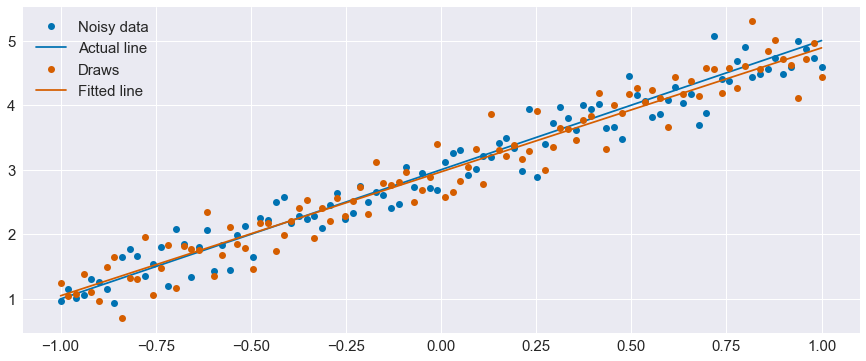

In [13]:
plot_line(xs, y, ys, y_hat, draw_data)

## References

https://twiecki.github.io/blog/2015/11/10/mcmc-sampling/

https://umbertopicchini.wordpress.com/2017/12/18/tips-for-coding-a-metropolis-hastings-sampler/

http://users.stat.umn.edu/~geyer/mcmc/burn.html

In [14]:
def plot_normal_distributions(mu_vals=(0.0, 0.5), sigma_vals=(1.0, 0.5), size=100, bounds=(-3, 3)):
    f, ax = plt.subplots(1, 1, figsize=(15, 6))
    
    mu = mu_vals[0]
    sigma = np.max(sigma_vals)
    x = np.linspace(mu + bounds[0] * sigma, mu + bounds[1] * sigma, size)
    
    for i in range(len(mu_vals)):
        for j in range(len(sigma_vals)):
            y = scipy.stats.norm.pdf(x, mu_vals[i], sigma_vals[j])
            ax.plot(x, y, label=f'μ = {mu_vals[i]}  σ = {sigma_vals[j]}')
    
    ax.legend()
    ax.set_title('Probability density function of several normal distributions')
    return f, ax

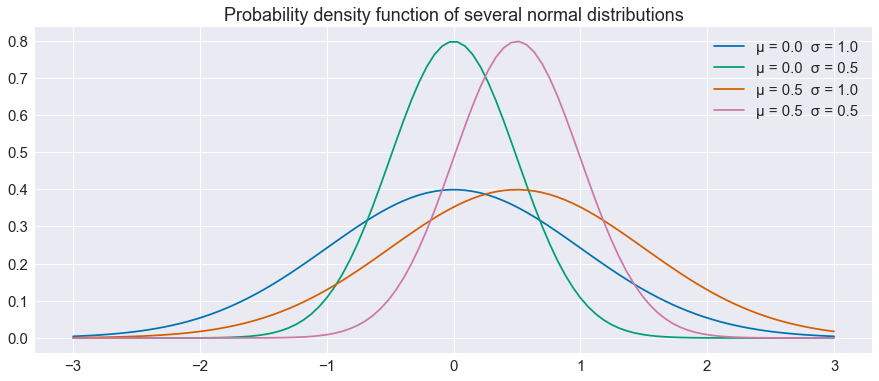

In [15]:
f, ax = plot_normal_distributions()
f.savefig(
    '/Users/srom/workspace/romainstrock.com/assets/img/linear_regression/normal.png', 
    bbox_inches='tight',
)

In [16]:
def plot_draws(num_draws=100):
    f, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    x_pdf = np.linspace(-3, 3, 100)
    x_draws = range(0, num_draws)
    
    for i, (mu, sigma) in enumerate([(0.0, 1.0), (0.0, 0.5)]):
        color = palette[0] if i == 0 else palette[2]
        norm = scipy.stats.norm(mu, sigma)
        y_pdf = norm.pdf(x_pdf)
        draws = norm.rvs(size=num_draws)
        axes[0].plot(x_pdf, y_pdf, label=f'N({mu}, {sigma})', color=color)
        axes[1].hist(draws, label=f'N({mu}, {sigma})', color=color, histtype='bar', alpha=0.7)
        axes[2].plot(x_draws, draws, 'o', label=f'N({mu}, {sigma})', color=color)
        
    axes[0].set_title('Probability density function')
    axes[1].set_title(f'Histogram ({num_draws} draws)')
    axes[2].set_title(f'Actual values ({num_draws} draws)')
        
    for i, ax in enumerate(axes):
        if i != 2:
            ax.legend()
    
    return f, axes

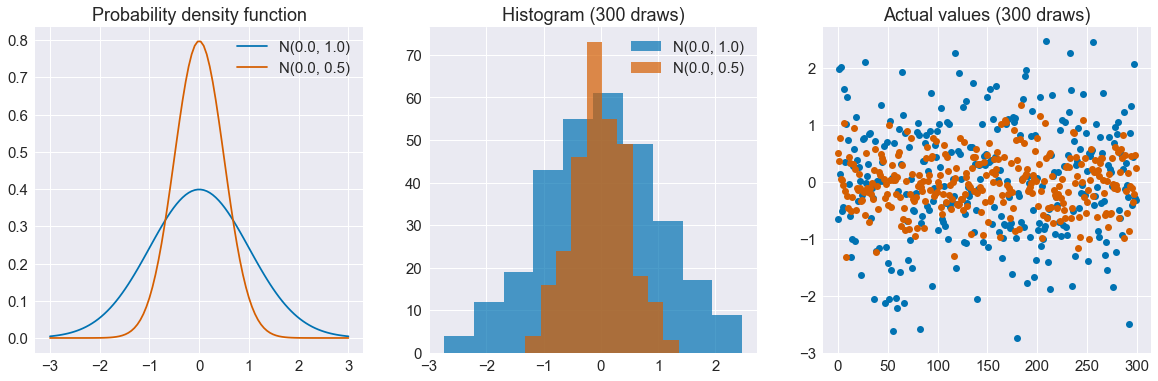

In [17]:
f, _ = plot_draws(300)
#f.savefig(
#    '/Users/srom/workspace/romainstrock.com/assets/img/linear_regression/normal_draws.png', 
#    bbox_inches='tight',
#)